# Examples

```
date: 2025-01-15
authors:
    - name: Brookie Guzder-Williams
affiliations:
    - University of California Berkeley, The Eric and Wendy Schmidt Center for Data Science & Environment
license: CC-BY-4.0
```

This notebook gives examples of how to use DSE's [Spectral Trend Database](https://github.com/SchmidtDSE/spectral_trend_database).  In particular we look at:

1. Querying the Database
2. Parsing the data
3. Visualizing the data


---

### IMPORTS


In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
from google.cloud import bigquery as bq
from spectral_trend_database.config import config as c
from spectral_trend_database import query
from spectral_trend_database import utils


---

### CONFIG

In [2]:
BQ_PREFIX = 'dse-regenag.SpectralTrendDatabase'
SAMPLE_FRAC = 0.0005
YEAR_START = 2008
YEAR_END = 2020
START_MMDD = '11-01'
END_MMDD = START_MMDD
ATTR_COLS = [
    'sample_id',
    'lon',
    'lat']
LIST_ATTRS = [
    'year',
    'biomass',
    'crop_type']
CHART_DATA_PATH = 'spectral_trends.chart_data.json'


---

### HELPER METHODS


In [3]:
def print_list(lst, max_len=7, view_size=3, sep=', ', connector=' ... '):
    size = len(lst)
    if size <= max_len:
        lst_str = sep.join(lst)
    else:
        head = sep.join(lst[:view_size])        
        tail = sep.join(lst[-view_size:])
        lst_str = f'{head}{connector}{tail}  [{size}]'
    print(lst_str)

def line(marker='-', length=100):
    print(marker*length)

## DATABSE QUERIES

---

### STDB DATABASE INFO

First we'll take a quick peak at the what is in the STDB database

In [4]:
SAMPLES_TABLE = 'SAMPLE_POINTS'
YIELD_TABLE = 'QDANN_YIELD'
SMOOTHED_INDICES_TABLE = 'SMOOTHED_INDICES_V1'
IDENT_DATE_COLUMNS = ['sample_id', 'year', 'date']

In [5]:
COLUMN_NAMES = {}
print('DATABASE INFO')
line()
table_names = query.table_names()
print('TABLES:')
pprint(table_names)
for table_name in [SAMPLES_TABLE, YIELD_TABLE, SMOOTHED_INDICES_TABLE]:
    COLUMN_NAMES[table_name] = query.column_names(table_name, run_query=True)
    print(f'\n{table_name}:')
    print_list(COLUMN_NAMES[table_name])
line()

DATABASE INFO
----------------------------------------------------------------------------------------------------
TABLES:
['QDANN_YIELD',
 'SMOOTHED_INDICES_V1',
 'INDICES_STATS_V1',
 'RAW_INDICES_V1',
 'SAMPLE_POINTS',
 'INDICES_STATS_V1_GROWING_SEASON',
 'INDICES_STATS_V1_OFF_SEASON',
 'CDL_CROP_TYPE',
 'MACD_INDICES_V1']

SAMPLE_POINTS:
AWATER, ALAND, LSAD ... h3_4, NAME, h3_9  [20]

QDANN_YIELD:
qdann_crop_label, qdann_crop_type, nb_years, biomass, year, sample_id

SMOOTHED_INDICES_V1:
si1, rvi, si ... savi, rdvi, year  [45]
----------------------------------------------------------------------------------------------------


In [6]:
INDICES = [c for c in COLUMN_NAMES[SMOOTHED_INDICES_TABLE] if c not in IDENT_DATE_COLUMNS]
print_list(INDICES)

si1, rvi, si ... blue, savi, rdvi  [42]



---

### USING BIG QUERY

The data is in a big-query database, and so can be accessed using the big-query api

In [7]:
#| label: nb.example_query_bq

client = bq.Client()
sql = f'SELECT sample_id, date, ndvi FROM `{BQ_PREFIX}.RAW_INDICES_V1` LIMIT 3'
resp = client.query(sql)
resp.to_dataframe()

,sample_id,date,ndvi
0,dp763hn7zdm,2005-05-27,0.257654
1,dp763hn7zdm,2005-04-09,0.195065
2,dp763hn7zdm,2005-03-16,0.018234



---

### QueryConstructor and Helper Methods

Using big-query directly is easy enough.  However, constructing SQL statements with lots of `JOIN` and `WHERE` statements can be painful.  To handle this we've developed a simple QueryConstructor. Additionaly we've added a few convience methods 
so the user never needs to use the big-query python module directly.  You've already seen two of them: `query.table_names` and `query.column_names`.

Let's start by reproducing the SQL in our simple example above

In [8]:
#| label: nb.example_query_stdb_basic

qc = query.QueryConstructor('RAW_INDICES_V1', table_prefix=BQ_PREFIX)
qc.select('sample_id', 'date', 'ndvi')
qc.limit(3)
df = query.run(sql=qc.sql())

print(qc.sql(),'\n')
df

SELECT sample_id, date, ndvi FROM `dse-regenag.SpectralTrendDatabase.RAW_INDICES_V1` LIMIT 3 



,sample_id,date,ndvi
0,dp763hn7zdm,2005-05-27,0.257654
1,dp763hn7zdm,2005-04-09,0.195065
2,dp763hn7zdm,2005-03-16,0.018234


Now we'll create an more complicated request using the sample_ids  from the above example.

First I'll need to select the sample_ids of interest

In [9]:
qc = query.QueryConstructor('SAMPLE_POINTS', table_prefix=BQ_PREFIX)
qc.select('DISTINCT sample_id')
qc.limit(3)
qc.sql()

'SELECT DISTINCT sample_id FROM `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS` LIMIT 3'

In [10]:
locales_df = query.run(sql=qc.sql())
sample_ids = locales_df.sample_id.tolist()
sample_ids

['9yrxd2cmudy', '9yry7n3rvb5', '9yryeyjyhre']

In [11]:
#| label: nb.example_query_stdb_advanced

qc = query.QueryConstructor(
        'SAMPLE_POINTS', 
        table_prefix=BQ_PREFIX,
        using=['sample_id'],  
        how='inner')
qc.join('MACD_INDICES_V1')
qc.join('SMOOTHED_INDICES_V1', 'sample_id', 'date')
qc.where_in(sample_id=sample_ids)
qc.where('SMOOTHED_INDICES_V1', year=2010, year_op='>=')
qc.where('SMOOTHED_INDICES_V1', year=2014, year_op='<')
qc.orderby('date', table='MACD_INDICES_V1')
df = query.run(sql=qc.sql(), print_sql=True)
example_id = df.sample_id.sample().iloc[0]
rows = df[df.sample_id == example_id]
rows

[info] spectral_trend_database.query.run: SELECT * FROM `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS` INNER JOIN `dse-regenag.SpectralTrendDatabase.MACD_INDICES_V1` USING (sample_id) INNER JOIN `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1` USING (sample_id, date) WHERE `dse-regenag.SpectralTrendDatabase.SAMPLE_POINTS`.sample_id IN ('9yrxd2cmudy', '9yry7n3rvb5', '9yryeyjyhre') AND `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1`.year >= 2010 AND `dse-regenag.SpectralTrendDatabase.SMOOTHED_INDICES_V1`.year < 2014 ORDER BY `dse-regenag.SpectralTrendDatabase.MACD_INDICES_V1`.date ASC


,sample_id,date,AWATER,ALAND,LSAD,STATE_NAME,STUSPS,GEOID,GEOIDFQ,NAMELSAD,...,nli,nir,red,evi2,rdi,gli,blue,savi,rdvi,year_1
0,9yry7n3rvb5,2010-01-01,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.515462,0.184004,0.105809,0.145417,0.925849,-0.002811,0.064496,0.148392,0.145185,2010
3,9yry7n3rvb5,2010-01-02,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.515956,0.183763,0.105674,0.145262,0.923275,-0.002924,0.064447,0.148261,0.145083,2010
7,9yry7n3rvb5,2010-01-03,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.516449,0.183523,0.105539,0.145108,0.920701,-0.003036,0.064397,0.148131,0.144981,2010
10,9yry7n3rvb5,2010-01-04,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.516943,0.183283,0.105403,0.144954,0.918127,-0.003145,0.064348,0.148001,0.144879,2010
13,9yry7n3rvb5,2010-01-05,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.517436,0.183042,0.105268,0.144800,0.915553,-0.003252,0.064299,0.147870,0.144777,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4380,9yry7n3rvb5,2013-12-27,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.368663,0.202382,0.088796,0.211021,0.394044,0.043123,0.055422,0.215235,0.210606,2013
4383,9yry7n3rvb5,2013-12-28,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.368892,0.201662,0.088187,0.211019,0.397006,0.043545,0.054799,0.215367,0.210870,2013
4388,9yry7n3rvb5,2013-12-29,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.369228,0.200876,0.087543,0.210973,0.400413,0.043969,0.054128,0.215466,0.211112,2013
4391,9yry7n3rvb5,2013-12-30,5497697,1655581941,6,Arkansas,AR,5021,0500000US05021,Clay County,...,-0.369667,0.200033,0.086874,0.210883,0.404252,0.044390,0.053417,0.215529,0.211329,2013


# PARSING THE DATA

---


We can easily turn these rows into xarray-datasets to more easily parse interact with the data.   

<xarray.Dataset>
Dimensions:        (date: 1465)
Coordinates:
  * date           (date) datetime64[ns] 2010-01-01 2010-01-02 ... 2013-12-31
Data variables: (12/59)
    ndvi_macd_div  (date) float64 1.611e-05 2.488e-05 ... -0.0004005 -0.0003559
    evi2_macd      (date) float64 -0.000444 -0.0004351 ... 0.0007866 0.0006279
    ndvi_macd      (date) float64 -0.00018 -0.0001588 ... 0.004363 0.00423
    evi2_ema_c     (date) float64 -0.0004568 -0.0004496 ... 0.001142 0.0009708
    ndvi_ema_c     (date) float64 -0.0001961 -0.0001836 ... 0.004763 0.004586
    evi2_ema_b     (date) float64 0.1462 0.146 0.1458 ... 0.2099 0.2101 0.2102
    ...             ...
    rdi            (date) float64 0.9258 0.9233 0.9207 ... 0.4004 0.4043 0.4085
    gli            (date) float64 -0.002811 -0.002924 ... 0.04439 0.0448
    blue           (date) float64 0.0645 0.06445 0.0644 ... 0.05342 0.05267
    savi           (date) float64 0.1484 0.1483 0.1481 ... 0.2155 0.2155 0.2156
    rdvi           (date) float64 0.1452 0.1451 0.145 ... 0.2111 0.2113 0.2115
    year_1         (date) int64 2010 2010 2010 2010 2010 ... 2013 2013 2013 2013
Attributes: (12/20)
    AWATER:      5497697
    ALAND:       1655581941
    LSAD:        6
    STATE_NAME:  Arkansas
    STUSPS:      AR
    GEOID:       5021
    ...          ...
    sample_id:   9yry7n3rvb5
    COUNTYNS:    63759
    lat:         36.2905455329
    h3_4:        84265d1ffffffff
    NAME:        Clay
    h3_9:        89265d119a7ffff

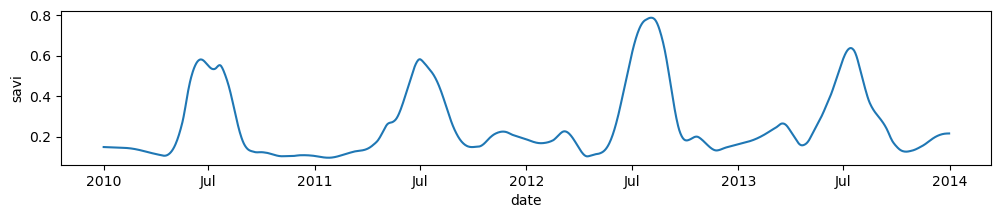

In [12]:
#| label: nb.rows_to_xr

ATTR_COLS = COLUMN_NAMES[SAMPLES_TABLE]
ds = utils.rows_to_xr(rows, attr_cols=ATTR_COLS)
fig, ax = plt.subplots(figsize=(12, 2))
ds.savi.plot(ax=ax)
display(ds)

xarrays can easily be filtered by dates

<xarray.Dataset>
Dimensions:        (date: 198)
Coordinates:
  * date           (date) datetime64[ns] 2012-04-01 2012-04-02 ... 2012-10-15
Data variables: (12/59)
    ndvi_macd_div  (date) float64 -0.001333 -0.001173 ... 0.003354 0.003064
    evi2_macd      (date) float64 -0.01032 -0.01045 ... 0.001321 0.001827
    ndvi_macd      (date) float64 -0.02025 -0.02067 ... -0.001293 -5.082e-05
    evi2_ema_c     (date) float64 -0.009741 -0.009979 ... -0.0004013 0.0003414
    ndvi_ema_c     (date) float64 -0.01891 -0.0195 ... -0.004647 -0.003115
    evi2_ema_b     (date) float64 0.1648 0.1605 0.1562 ... 0.191 0.192 0.1932
    ...             ...
    rdi            (date) float64 1.082 1.112 1.141 ... 0.7959 0.786 0.7754
    gli            (date) float64 0.02366 0.02139 0.01914 ... 0.005469 0.006241
    blue           (date) float64 0.08681 0.08825 0.08971 ... 0.07463 0.0741
    savi           (date) float64 0.1425 0.1379 0.1334 ... 0.1918 0.1935 0.1951
    rdvi           (date) float64 0.1361 0.1316 0.1272 ... 0.1829 0.1845 0.186
    year_1         (date) int64 2012 2012 2012 2012 2012 ... 2012 2012 2012 2012
Attributes: (12/20)
    AWATER:      5497697
    ALAND:       1655581941
    LSAD:        6
    STATE_NAME:  Arkansas
    STUSPS:      AR
    GEOID:       5021
    ...          ...
    sample_id:   9yry7n3rvb5
    COUNTYNS:    63759
    lat:         36.2905455329
    h3_4:        84265d1ffffffff
    NAME:        Clay
    h3_9:        89265d119a7ffff

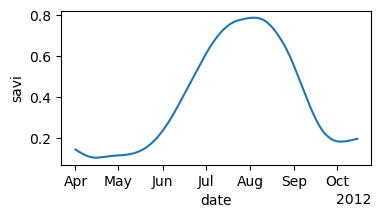

In [13]:
#| label: nb.filter_by_dates

START_MMDD = '04-01'
END_MMDD = '10-15'

def growing_season_for_year(ds, year):
    return ds.sel(dict(date=slice(f'{year}-{START_MMDD}', f'{year}-{END_MMDD}')))

_ds = growing_season_for_year(ds, 2012)
fig, ax = plt.subplots(figsize=(4, 2))
_ds.savi.plot(ax=ax)
display(_ds)


---

## Computations and Visulaizations


In [14]:
SUPTITLE = 'Spectral Trends'
TITLE = 'Normalized Difference Vegetation Index and it\'s Exponentially Weighted Moving Average'
SUPTITLE_FONT_SIZE = 22
SUPTITLE_CLR = '#555'
TITLE_FONT_SIZE = 14
TITLE_CLR = '#999'
LABEL_FONT_SIZE = 16
LABEL_CLR = '#333'

In [15]:
def twinx_legend(ax, ax2):
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    return ax2.legend(lines + lines2, labels + labels2, loc=0)

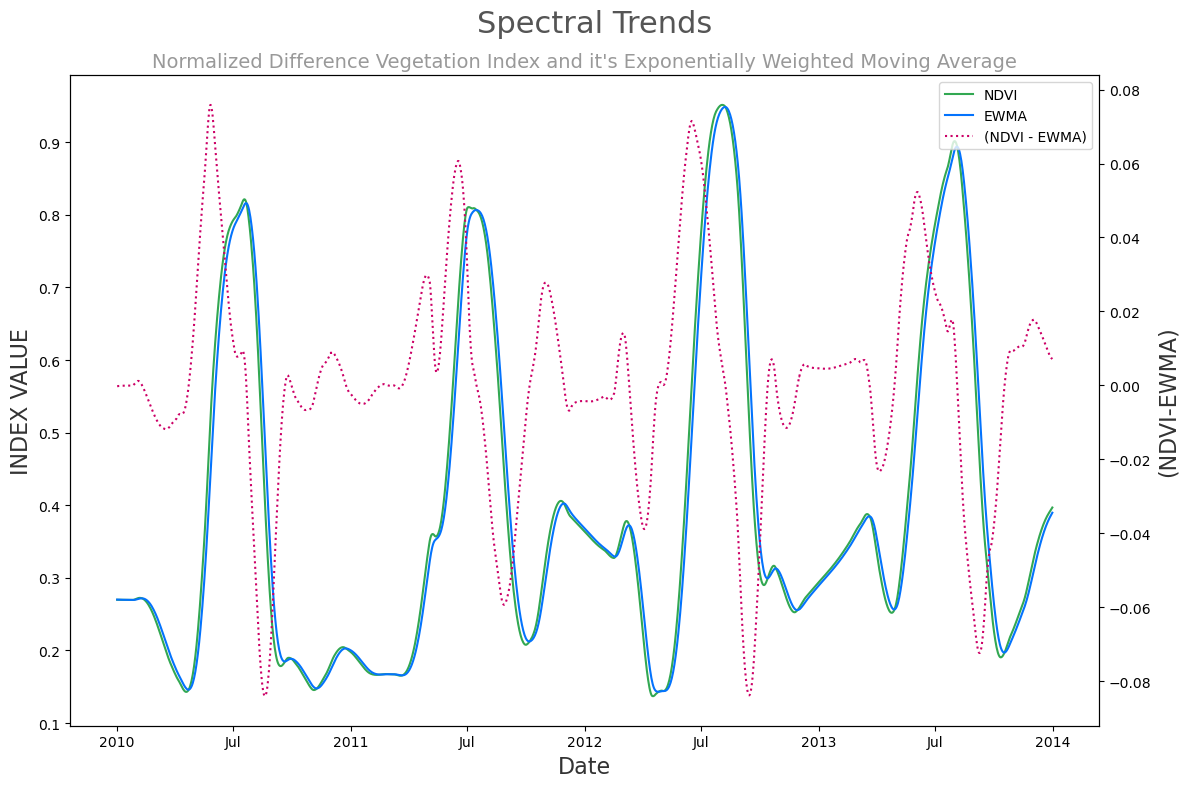

In [16]:
#| label: nb.ndvi_vs_ema

fig, ax = plt.subplots(figsize=(12, 8))
ax2 = ax.twinx()

(ds.ndvi - ds.ndvi_ema_b).plot(color='#cc0066', linestyle='dotted', label='(NDVI - EWMA)', ax=ax2)
ds.ndvi.plot(color='#32a852', label='NDVI', ax=ax)
ds.ndvi_ema_b.plot(color='#0473fd', label='EWMA', ax=ax)

plt.title(TITLE,fontsize=TITLE_FONT_SIZE,color=TITLE_CLR)
plt.suptitle(SUPTITLE,fontsize=SUPTITLE_FONT_SIZE,color=SUPTITLE_CLR)

ax.set_ylabel('INDEX VALUE', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax2.set_ylabel('(NDVI-EWMA)', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax.set_xlabel('Date', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
twinx_legend(ax, ax2)

plt.tight_layout()